# LSA Exercise

The purpose of this exercise is to use LSA in order to run unsupervised topic extraction on texts and compare the results to the target variable. We are not going to use the target variable to train a model but only to assess if the topics found by LSA are similar to the classes that would have been used for supervised classification.

1. Let's begin and import the libraries we will be using

In [1]:
import pandas as pd 
import numpy as np
import en_core_web_sm
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

2. Load the 20 news dataset into an object news

In [2]:
news = fetch_20newsgroups()

3. Display the data description using the DESCR key

In [3]:
print(news.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

4. Store the object news.data in a DataFrame and call the column text. Extract a sample of 5000 rows to begin with. Add the target variable to this dataframe in order to run analysis later.

In [4]:
data = pd.DataFrame(news.data, columns =["text"])
data = data.sample(5000)
data["target"] = news.target[data.index]
data.head()

,text,target
6180,From: jbulf@balsa.Berkeley.EDU (Jeff Bulf)\nSu...,1
6561,From: trrrc@rc.rit.edu (Thomas R. Ridley)\nSub...,4
9849,From: wb8foz@skybridge.SCL.CWRU.Edu (David Les...,12
6601,From: kedz@bigwpi.WPI.EDU (John Kedziora)\nSub...,6
11112,From: decay@cbnewsj.cb.att.com (dean.kaflowitz...,18


5. Create a column text_clean containing only alphanumerical characters and change all characters to lowercase. Also only keep the tex that is after the string "Subject:"

In [5]:
data['text_clean'] = data['text'].apply(lambda x: x.split("Subject:")[1])
data['text_clean'] = data['text_clean'].apply(lambda x: ''.join(ch for ch in x if ch.isalnum() or ch==" "))
data['text_clean'] = data['text_clean'].fillna('').apply(lambda x: x.lower())
data.head()

,text,target,text_clean
6180,From: jbulf@balsa.Berkeley.EDU (Jeff Bulf)\nSu...,1,re detecting double points in bezier curvesre...
6561,From: trrrc@rc.rit.edu (Thomas R. Ridley)\nSub...,4,token ring cards for macsnntppostinghost muts...
9849,From: wb8foz@skybridge.SCL.CWRU.Edu (David Les...,12,re exploding tvorganization nrk clinic for ha...
6601,From: kedz@bigwpi.WPI.EDU (John Kedziora)\nSub...,6,motorcycle wantedorganization worcester polyt...
11112,From: decay@cbnewsj.cb.att.com (dean.kaflowitz...,18,re i thought commercial advertising was not a...


6. Create an object nlp with ```en_core_web_sm.load``` 

In [6]:
nlp = en_core_web_sm.load()

7. Tokenize the cleaned sentences and remove english stopwords

In [7]:
from spacy.lang.en.stop_words import STOP_WORDS

data["text_tokenized"] = data["text_clean"].apply(lambda x: [token.lemma_ for token in nlp(x) if token.text not in STOP_WORDS])
data.head()

,text,target,text_clean,text_tokenized
6180,From: jbulf@balsa.Berkeley.EDU (Jeff Bulf)\nSu...,1,re detecting double points in bezier curvesre...,"[ , detect, double, point, bezier, curvesreply..."
6561,From: trrrc@rc.rit.edu (Thomas R. Ridley)\nSub...,4,token ring cards for macsnntppostinghost muts...,"[ , token, ring, card, macsnntppostinghost, mu..."
9849,From: wb8foz@skybridge.SCL.CWRU.Edu (David Les...,12,re exploding tvorganization nrk clinic for ha...,"[ , explode, tvorganization, nrk, clinic, habi..."
6601,From: kedz@bigwpi.WPI.EDU (John Kedziora)\nSub...,6,motorcycle wantedorganization worcester polyt...,"[ , motorcycle, wantedorganization, worcester,..."
11112,From: decay@cbnewsj.cb.att.com (dean.kaflowitz...,18,re i thought commercial advertising was not a...,"[ , think, commercial, advertising, allowedorg..."


8. Detokenize the tokenized sentences and store them in an ```nlp_ready``` column

In [8]:
# de-tokenization
detokenized_doc = []
for sentence in data["text_tokenized"]:
    t = ' '.join(sentence)
    detokenized_doc.append(t)

data['nlp_ready'] = detokenized_doc
data.head()

,text,target,text_clean,text_tokenized,nlp_ready
6180,From: jbulf@balsa.Berkeley.EDU (Jeff Bulf)\nSu...,1,re detecting double points in bezier curvesre...,"[ , detect, double, point, bezier, curvesreply...",detect double point bezier curvesreplyto jbu...
6561,From: trrrc@rc.rit.edu (Thomas R. Ridley)\nSub...,4,token ring cards for macsnntppostinghost muts...,"[ , token, ring, card, macsnntppostinghost, mu...",token ring card macsnntppostinghost mutsurcr...
9849,From: wb8foz@skybridge.SCL.CWRU.Edu (David Les...,12,re exploding tvorganization nrk clinic for ha...,"[ , explode, tvorganization, nrk, clinic, habi...",explode tvorganization nrk clinic habitual n...
6601,From: kedz@bigwpi.WPI.EDU (John Kedziora)\nSub...,6,motorcycle wantedorganization worcester polyt...,"[ , motorcycle, wantedorganization, worcester,...",motorcycle wantedorganization worcester poly...
11112,From: decay@cbnewsj.cb.att.com (dean.kaflowitz...,18,re i thought commercial advertising was not a...,"[ , think, commercial, advertising, allowedorg...",think commercial advertising allowedorganiza...


9. Use sklearn to calculate the tf-idf

In [9]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english', smooth_idf=True)
X = vectorizer.fit_transform(data['nlp_ready'])
X

<5000x119770 sparse matrix of type '<class 'numpy.float64'>'
	with 460115 stored elements in Compressed Sparse Row format>

10. Use the truncatedSVD model in order to create a topic model with 20 different topics

In [10]:
# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100)
lsa = svd_model.fit_transform(X)

topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_{}".format(i+1) for i in range(20)], index = data.index)
topic_encoded_df["text"] = data['nlp_ready'].values
topic_encoded_df

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,text
6180,0.086033,-0.010621,0.001903,0.004120,-0.024886,-0.006121,-0.013625,0.036739,-0.012943,0.016129,...,-0.012105,-0.008895,-0.008703,-0.017029,-0.047767,-0.012000,-0.024928,-0.000039,0.011462,detect double point bezier curvesreplyto jbu...
6561,0.053401,-0.023221,0.001615,-0.001642,0.007327,0.004588,0.001697,0.040750,0.036004,0.003025,...,-0.039604,0.016316,0.022890,0.021552,0.009736,-0.017204,-0.009999,-0.006840,0.009925,token ring card macsnntppostinghost mutsurcr...
9849,0.026837,-0.000442,-0.003646,-0.003124,0.002150,-0.006412,0.002036,-0.000486,-0.009197,0.000724,...,0.000989,-0.013123,-0.003253,0.009090,0.003691,-0.000688,0.011779,-0.006364,-0.005261,explode tvorganization nrk clinic habitual n...
6601,0.046196,-0.027614,-0.009151,-0.007254,-0.003801,0.006831,-0.022574,0.022912,-0.039490,-0.015730,...,-0.013565,0.008945,0.014430,-0.027626,-0.011508,-0.021327,0.012717,0.011340,-0.006035,motorcycle wantedorganization worcester poly...
11112,0.148811,0.063196,0.035730,0.029841,0.018006,-0.022493,-0.029996,-0.027816,0.027548,0.022501,...,0.005965,-0.031978,-0.004386,0.007967,-0.001960,-0.012911,-0.019598,-0.008626,0.015906,think commercial advertising allowedorganiza...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3009,0.128320,-0.064126,-0.030226,0.140666,-0.110068,0.010626,0.048839,-0.020320,-0.020427,-0.020506,...,0.025951,0.009052,0.003552,0.014231,-0.059549,0.042769,0.021789,0.028824,0.030086,shelf cheap des keyseach machine corporate a...
2866,0.048838,-0.083045,0.038211,-0.021379,0.039512,0.090060,0.068900,-0.019439,0.032804,-0.006632,...,0.057872,0.019334,0.062582,0.001820,0.008957,-0.010550,-0.015527,-0.005827,-0.010305,do 6from darrenlavalleecld9sccsicom darren l...
969,0.047842,-0.026807,0.006421,-0.002631,0.010046,0.025514,0.007127,0.007205,-0.016601,-0.003093,...,-0.037458,-0.002468,-0.003614,-0.002444,0.024843,-0.006841,0.016219,-0.031316,-0.025501,512 kb vram simmsnntppostinghost lkhp20hutfi...
5861,0.103929,-0.014483,-0.037103,0.022632,-0.013163,0.036197,-0.046089,0.008536,-0.058177,-0.055685,...,0.062223,-0.008113,0.028013,0.035653,0.002579,-0.050913,0.074636,0.149288,-0.070764,observation helmetsorganization nec system l...


11. Assign each document to the topic it is the most linked to :

In [11]:
topic_encoded_df["class_pred"] = [np.argmax(topic) for topic in lsa]
topic_encoded_df["class_pred"].value_counts()

0     3834
18     128
3      121
5      121
7      100
4       73
1       65
16      63
9       61
10      61
13      59
17      57
2       48
11      40
14      38
15      37
12      34
19      32
6       21
8        7
Name: class_pred, dtype: int64

12. Add the target variable to thetopic model dataframe and print the confusion matrix for the topic against the target variable :

In [12]:
topic_encoded_df["target"] = news.target[data.index]
topic_encoded_df.head()

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,text,class_pred,target
6180,0.086033,-0.010621,0.001903,0.004120,-0.024886,-0.006121,-0.013625,0.036739,-0.012943,0.016129,...,-0.008703,-0.017029,-0.047767,-0.012000,-0.024928,-0.000039,0.011462,detect double point bezier curvesreplyto jbu...,0,1
6561,0.053401,-0.023221,0.001615,-0.001642,0.007327,0.004588,0.001697,0.040750,0.036004,0.003025,...,0.022890,0.021552,0.009736,-0.017204,-0.009999,-0.006840,0.009925,token ring card macsnntppostinghost mutsurcr...,0,4
9849,0.026837,-0.000442,-0.003646,-0.003124,0.002150,-0.006412,0.002036,-0.000486,-0.009197,0.000724,...,-0.003253,0.009090,0.003691,-0.000688,0.011779,-0.006364,-0.005261,explode tvorganization nrk clinic habitual n...,0,12
6601,0.046196,-0.027614,-0.009151,-0.007254,-0.003801,0.006831,-0.022574,0.022912,-0.039490,-0.015730,...,0.014430,-0.027626,-0.011508,-0.021327,0.012717,0.011340,-0.006035,motorcycle wantedorganization worcester poly...,0,6
11112,0.148811,0.063196,0.035730,0.029841,0.018006,-0.022493,-0.029996,-0.027816,0.027548,0.022501,...,-0.004386,0.007967,-0.001960,-0.012911,-0.019598,-0.008626,0.015906,think commercial advertising allowedorganiza...,0,18


Text(159.0, 0.5, 'True label')

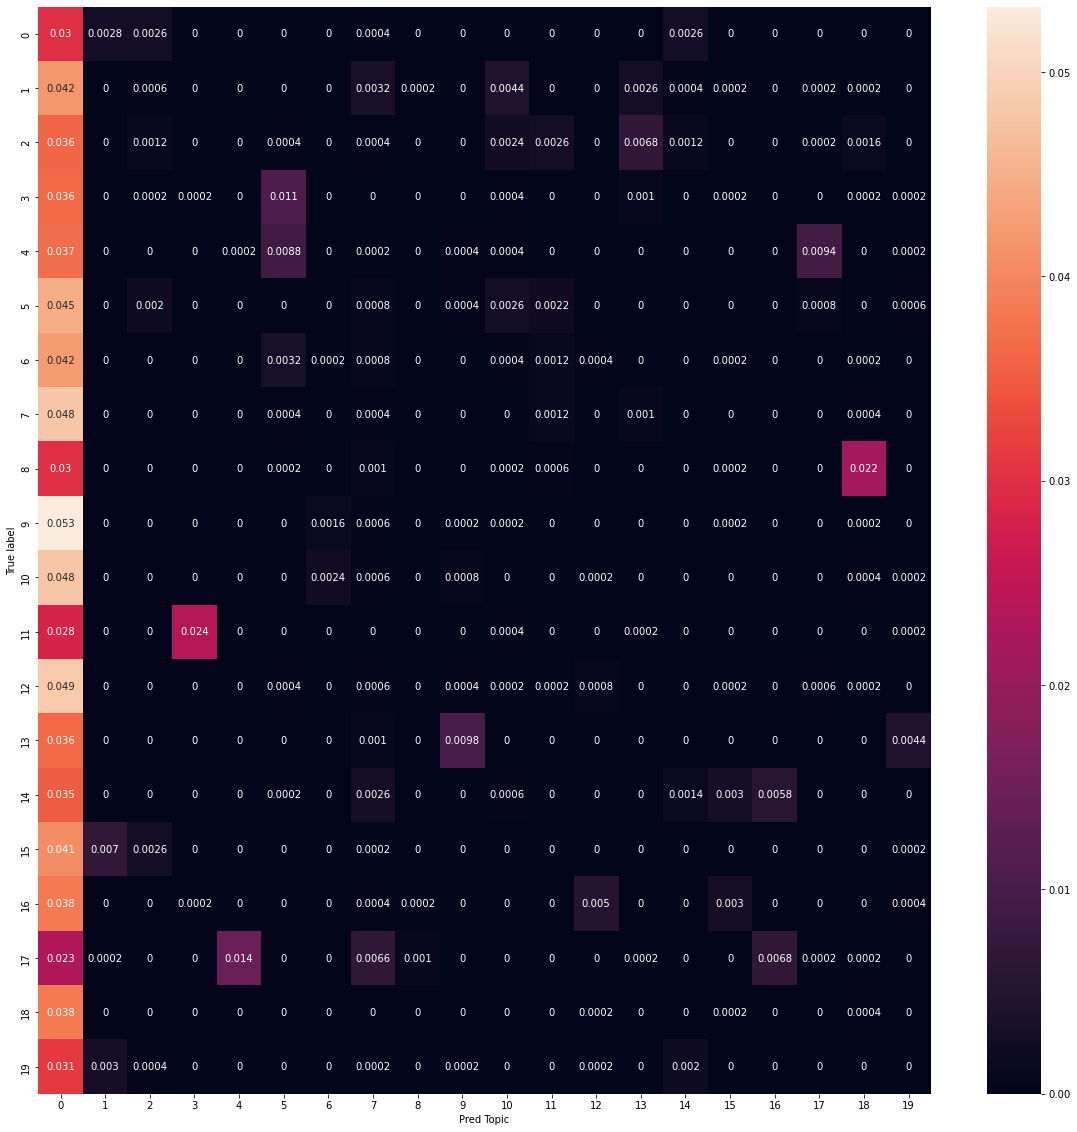

In [13]:
cm = confusion_matrix(y_true = topic_encoded_df["target"], y_pred = topic_encoded_df["class_pred"]) / 5000

fig, ax = plt.subplots(1,1, figsize = (20,20))
sns.heatmap(cm, annot=True)
ax.set_xlabel("Pred Topic")
ax.set_ylabel("True label")

Conclusion : the topics found by LSA are very different from the target ! Here we can see that topic 0 is very frequent among the documents and spans accross lots of the target categories. 
LSA is very convenient to find some structure among a text corpus, but it usually creates topics that are quite different from the categories that would have been determined by a human.

Reminder : contrary to supervised classification and unsupervised clustering, LSA is based on the hypothesis that a given document can be related to several topics. This makes the interpretation of the model's output more complicated, but allows to create topic models that are more realistic (because in real life, a document is often related to different topics !)